# Comparing activation functions for a minimal model
The opposing paper argues that input compression is merely an artifact of saturating activation functions. We test this assumption for the minimal model in a numeric simulation. We look at the development of mututal information with the input for a one neuron model for different activation functions with growing weights.

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

/home/jarno/.miniconda/envs/dneck/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [65]:
weights = np.arange(0.1, 8, 0.1)

In [66]:
weights

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9])

The input is sampled from a standard normal distribution.

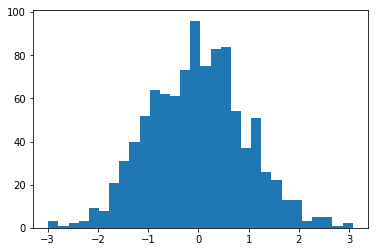

In [67]:
input_distribution = stats.norm()
input_ = input_distribution.rvs(1000)
plt.hist(input_, bins=30);

In [68]:
net_input = np.outer(weights, input_)

In [69]:
net_input

array([[-9.06221958e-03,  1.34311643e-01, -1.05828157e-01, ...,
        -3.56951147e-02, -6.74676148e-03, -1.09384400e-01],
       [-1.81244392e-02,  2.68623287e-01, -2.11656314e-01, ...,
        -7.13902294e-02, -1.34935230e-02, -2.18768800e-01],
       [-2.71866587e-02,  4.02934930e-01, -3.17484471e-01, ...,
        -1.07085344e-01, -2.02402844e-02, -3.28153201e-01],
       ...,
       [-6.97790907e-01,  1.03419965e+01, -8.14876808e+00, ...,
        -2.74852383e+00, -5.19500634e-01, -8.42259881e+00],
       [-7.06853127e-01,  1.04763082e+01, -8.25459624e+00, ...,
        -2.78421895e+00, -5.26247396e-01, -8.53198321e+00],
       [-7.15915346e-01,  1.06106198e+01, -8.36042440e+00, ...,
        -2.81991406e+00, -5.32994157e-01, -8.64136761e+00]])

In [70]:
a = [1, 10, 100]
b = [1,2,3]
np.outer(a,b)

array([[  1,   2,   3],
       [ 10,  20,  30],
       [100, 200, 300]])

The activation functions we want to test.

In [71]:
def hard_sigmoid(x):
    lower_bound = -2.5
    upper_bound = 2.5
    linear = 0.2 * x + 0.5
    linear[x < lower_bound] = 0
    linear[x > upper_bound] = 1
    return linear

def linear(x):
    return x

activation_functions = [tf.nn.sigmoid, tf.nn.tanh, tf.nn.relu, tf.nn.softsign, tf.nn.softplus, hard_sigmoid, 
                       tf.nn.selu, tf.nn.relu6, tf.nn.elu, tf.nn.leaky_relu, linear]

First we look at the shape of the different activation functions. We see that some are saturating like `tanh` and some are not like `relu`.

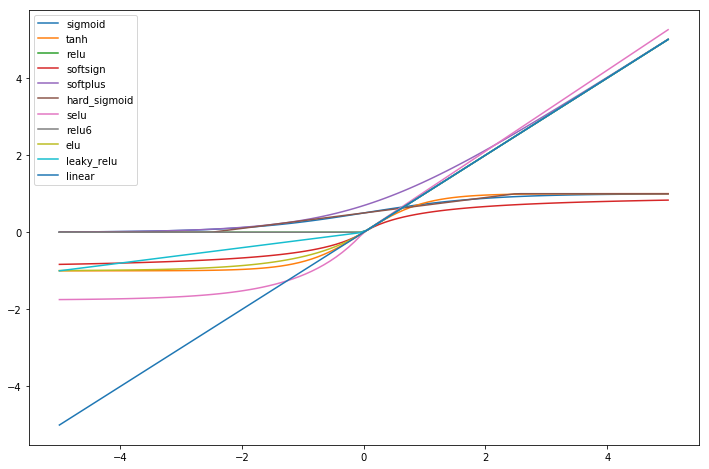

In [72]:
fig, ax = plt.subplots(figsize=(12, 8))
for actvation_function in activation_functions:
    x = np.linspace(-5,5,100)
    ax.plot(x, actvation_function(x), label=actvation_function.__name__)
plt.legend()

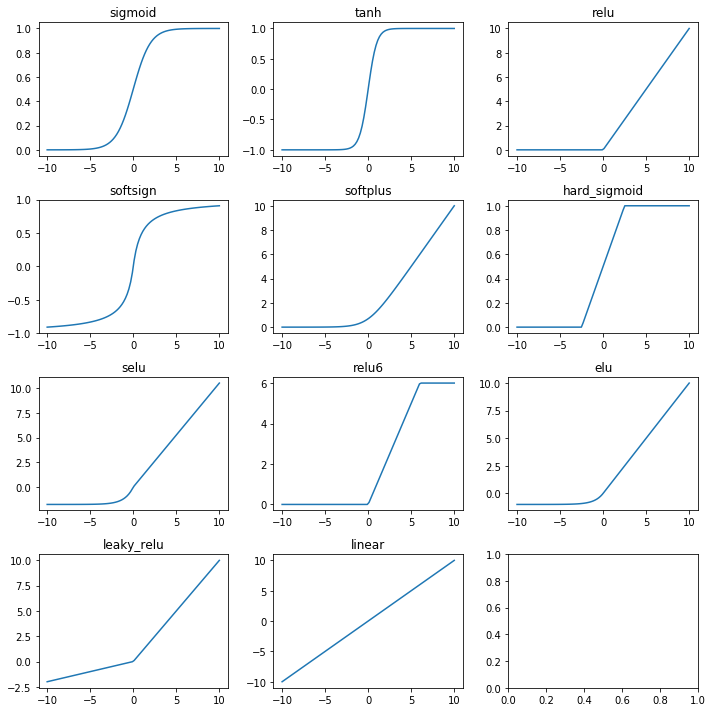

In [73]:
fig, ax = plt.subplots(nrows=int(len(activation_functions)/3)+1, ncols=3, figsize=(10, 10))
ax = ax.flat

for i, actvation_function in enumerate(activation_functions):
    x = np.linspace(-10,10,100)
    ax[i].plot(x, actvation_function(x))
    ax[i].set(title=actvation_function.__name__)
plt.tight_layout()

In [74]:
outputs = {}
for actvation_function in activation_functions:
    try:
        outputs[actvation_function.__name__] = actvation_function(net_input).numpy()
    except AttributeError:
        outputs[actvation_function.__name__] = actvation_function(net_input)

5.571972783556241
5.571972783556241
3.2642520281166294
5.25022701625838
3.4865799183658903
5.466656510359543
3.7462944324574012
3.5522123000705266
3.6023055235073635
4.528032498470691
4.965373809500078


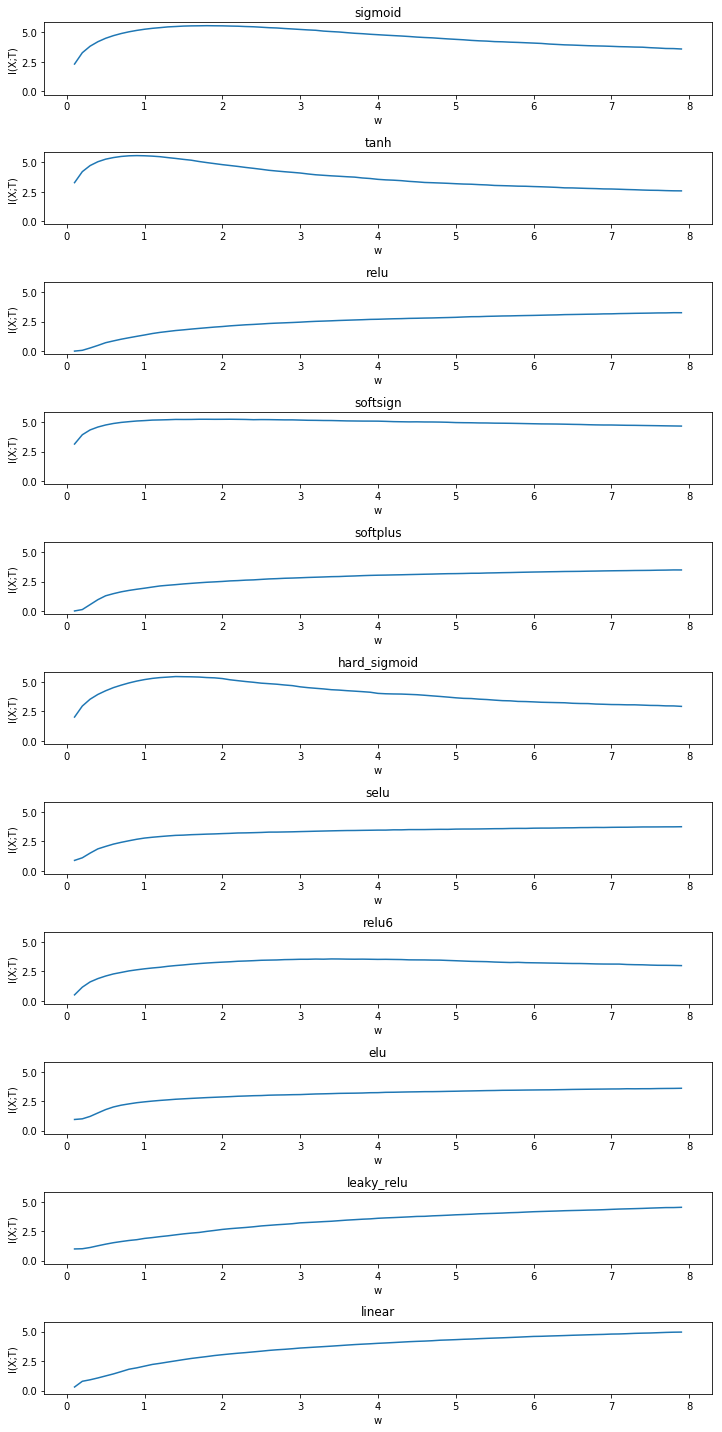

In [76]:
fig, ax = plt.subplots(nrows=len(outputs), figsize=(10, 20), sharey=True)
ax = ax.flat
for ax_idx, (activation_function, Y) in enumerate(outputs.items()):
    min_acitivity = Y.min()
    max_acitivity = Y.max()
    
    mi = np.zeros(len(weights))
    for i in range(len(weights)):
        binsize = 0.07
        bins = np.linspace(min_acitivity, max_acitivity, 50)
        digitized, _ = np.histogram(Y[i], bins=bins)
        
        mi[i] = stats.entropy(digitized, base=2) 
    print(mi.max())

    ax[ax_idx].plot(weights,  mi)
    ax[ax_idx].set(title=activation_function, xlabel='w', ylabel='I(X;T)') 
plt.tight_layout()

5.600175960302056
5.597371773765895
3.2805876237220377
5.507299433273827
4.985396352633899
5.494406477671763
5.205862784956476
3.5666170326793134
5.103201751349092
4.574897550293193
4.997472729737219


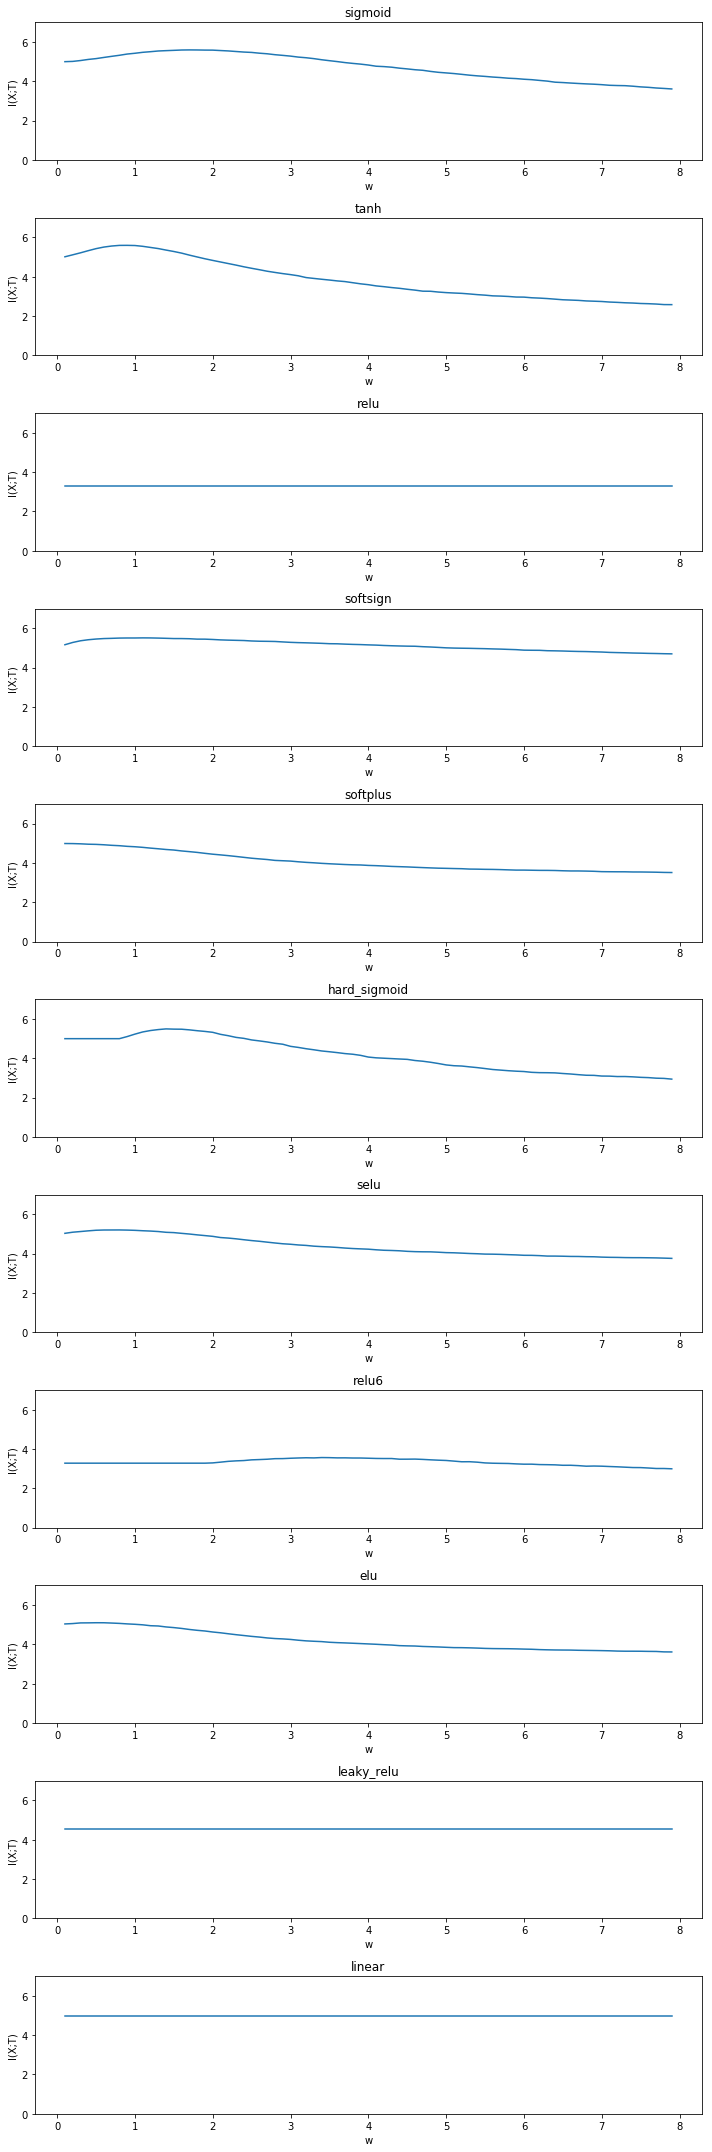

In [75]:
fig, ax = plt.subplots(nrows=len(outputs), figsize=(10, 30), sharey=True)
ax = ax.flat
for ax_idx, (activation_function, Y) in enumerate(outputs.items()):
    min_acitivity = Y.min()
    max_acitivity = Y.max()
    
    mi = np.zeros(len(weights))
    for i in range(len(weights)):
        digitized, _ = np.histogram(Y[i], bins=50)
        
        mi[i] = stats.entropy(digitized, base=2) 
    print(mi.max())
    ax[ax_idx].plot(weights,  mi)
    ax[ax_idx].set(title=activation_function, xlabel='w', ylabel='I(X;T)', ylim=[0,7]) 
    
plt.tight_layout()

In [63]:
dig, _ = np.histogram(input_, 50)
stats.entropy(dig, base=2)

4.898119442543784